In [1]:
!pip install -q torch-geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.8 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
from torch import Tensor
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
from torch.optim import Adam
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score




In [5]:
from torch_geometric.datasets import WikiCS

dataset = WikiCS(root='/tmp/WikiCS')
data = dataset[0]

print(f"Nodes: {data.num_nodes}")
print(f"Features: {data.num_node_features}")
print(f"Classes: {dataset.num_classes}")

/tmp/ipython-input-3596689098.py:3: UserWarning: The WikiCS dataset now returns an undirected graph by default. Please explicitly specify 'is_undirected=False' to restore the old behavior.
  dataset = WikiCS(root='/tmp/WikiCS')
Processing...


Nodes: 11701
Features: 300
Classes: 10


Done!


In [6]:
data.train_mask[:10]

tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False,  True, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False],
        [ True, False, False, False, False, False, False, False, False, False,
         False, False, False,  True, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False,  True, False],
        [False, False, False, False, False, Fa

In [7]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 64)
        self.conv2 = GCNConv(64, 64)
        self.conv3 = GCNConv(64, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x1 = F.dropout(F.relu(self.conv1(x, edge_index)), p=0.4, training=self.training)
        x2 = F.dropout(F.relu(self.conv2(x1, edge_index) + x1), p=0.4, training=self.training)
        x3 = self.conv3(x2, edge_index)
        return F.log_softmax(x3, dim=1)

model = GCN()
optimizer = Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [ ]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask[:, 0]], data.y[data.train_mask[:, 0]])
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def test():
    model.eval()
    logits = model(data)
    accs = []
    for split in range(data.train_mask.size(1)):
        mask = data.train_mask[:, split]
        val_mask = data.val_mask[:, split]
        test_mask = data.test_mask
        pred = logits[mask].max(1)[1]
        train_acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        pred_val = logits[val_mask].max(1)[1]
        val_acc = pred_val.eq(data.y[val_mask]).sum().item() / val_mask.sum().item()
        pred_test = logits[test_mask].max(1)[1]
        test_acc = pred_test.eq(data.y[test_mask]).sum().item() / test_mask.sum().item()
        accs.append((train_acc, val_acc, test_acc))
    return accs

In [ ]:
best_val = 0
patience = 20
patience_counter = 0
max_epochs = 200

for epoch in range(1, max_epochs + 1):
    loss = train()
    accs = test()
    avg_train = sum(a[0] for a in accs)/len(accs)
    avg_val = sum(a[1] for a in accs)/len(accs)
    avg_test = sum(a[2] for a in accs)/len(accs)
    if avg_val > best_val:
        best_val = avg_val
        torch.save(model.state_dict(), 'best_gcn_wikics.pt')
        patience_counter = 0
    else:
        patience_counter += 1
    if patience_counter >= patience:
        break
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:3d}, Loss: {loss:.4f}, Train: {avg_train:.4f}, Val: {avg_val:.4f}, Test: {avg_test:.4f}')

Epoch:  10, Loss: 0.4589, Train: 0.8066, Val: 0.8070, Test: 0.7874
Epoch:  20, Loss: 0.4544, Train: 0.8047, Val: 0.8057, Test: 0.7852
Epoch:  30, Loss: 0.4246, Train: 0.8046, Val: 0.8060, Test: 0.7854
Epoch:  40, Loss: 0.4088, Train: 0.8054, Val: 0.8060, Test: 0.7898


In [8]:
model.load_state_dict(torch.load('/content/best_gcn_wikics.pt'))
model.eval()

with torch.no_grad():
    out = model(data)
    pred = out.max(1)[1]

test_mask = data.test_mask
test_acc = pred[test_mask].eq(data.y[test_mask]).sum().item() / test_mask.sum().item()
print(f'Test Accuracy: {test_acc:.4f}')
print("Predictions:", pred[test_mask][:10].tolist())
print("Ground Truth:", data.y[test_mask][:10].tolist())

Test Accuracy: 0.7913
Predictions: [2, 2, 2, 4, 9, 0, 9, 7, 7, 4]
Ground Truth: [2, 4, 2, 4, 9, 0, 9, 7, 7, 4]


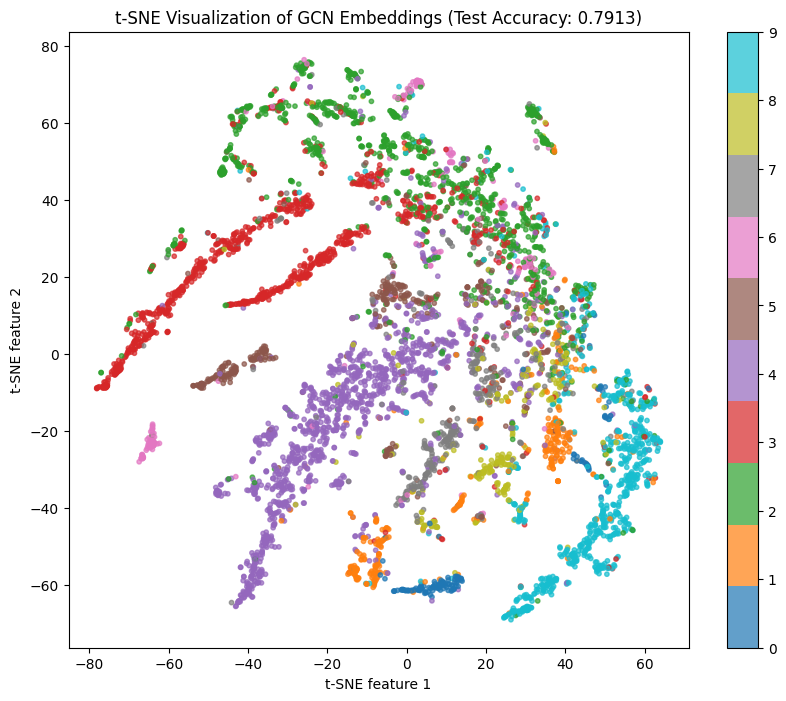

In [11]:
model.load_state_dict(torch.load('best_gcn_wikics.pt'))
model.eval()

with torch.no_grad():
    out = model(data)

tsne = TSNE(n_components=2, random_state=42)
test_embeddings_2d = tsne.fit_transform(out[data.test_mask].cpu().numpy())
test_labels = data.y[data.test_mask].cpu().numpy()

plt.figure(figsize=(10, 8))
scatter = plt.scatter(test_embeddings_2d[:, 0], test_embeddings_2d[:, 1],
            c=test_labels, cmap='tab10', s=10, alpha=0.7)
plt.colorbar(scatter, ticks=range(10))
plt.title(f't-SNE Visualization of GCN Embeddings (Test Accuracy: {test_acc:.4f})')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()